# Predição de COVID-19 em Raio-X Pulmonar

Neste trabalho, vamos desenvolver um modelo para classificação de Raio-X pulmonares de pessoas saudáveis e de pessoas que estão ou já tiveram contato com o novo coronavírus.

A escolha do tópico veio devido a necessidade de achar novos caminhos para o reconhecimento de casos de pessoas que estão com a doença, ou já tiveram contato com ela, sobretudo esta última. Isto porque o teste mais utilizado no momento para prever se uma pessoa teve ou não contato com a doença consiste em verificar se a mesma possui os anticorpos da doença e, como já foi constatado, algumas pessoas simplesmente não produzem o anticorpo.

Esse fenômeno atrapalha os agentes públicos de saúde na sua batalha para a contenção dos novo casos. Portanto, a partir dessa necessidade, esse modelo foi desenvolvido.

## 1 Preparando o Dataset

O dataset que estamos utilizando foi retirado do [Kaggle](https://www.kaggle.com/plameneduardo/sarscov2-ctscan-dataset) e consiste em dois diretórios, sendo o primeiro "non-COVID" contendo imagens de raio-x de pulmões de pessoas saudáveis e o segundo "COVID" com imagens de raio-x de pulmões de pessoas que estão ou que já tiveram contato com o novo Coronavírus.

### 1.1 Extraindo o dataset do GitHub

Abaixo, estaremos fazendo a cópia do nosso dataset do [repositório do GitHub](https://github.com/Lucastmarques/Covid_vs_non-Covid) para o ambiente de execução do Colab (`/content/`), para que seja possível a sua manipulação de forma mais simples.

In [19]:
 # Faz o download da base dados no /content/ do Colab
 !wget https://github.com/Lucastmarques/Covid_vs_non-Covid/blob/87fd26e487c4b82f6f54ea1fa35243df52bc6a54/covid_or_non-covid.zip

Após isso, precisamos descompactar o arquivo. Para isso, vamos utilizar o comando `unzip` do próprio linux.

In [20]:
# Unzip no dataset do Kaggle
!unzip /content/covid_or_non-covid.zip

Archive:  /content/covid_or_non-covid.zip
  inflating: COVID/Covid (1).png     
  inflating: COVID/Covid (10).png    
  inflating: COVID/Covid (100).png   
  inflating: COVID/Covid (1000).png  
  inflating: COVID/Covid (1001).png  
  inflating: COVID/Covid (1002).png  
  inflating: COVID/Covid (1003).png  
  inflating: COVID/Covid (1004).png  
  inflating: COVID/Covid (1005).png  
  inflating: COVID/Covid (1006).png  
  inflating: COVID/Covid (1007).png  
  inflating: COVID/Covid (1008).png  
  inflating: COVID/Covid (1009).png  
  inflating: COVID/Covid (101).png   
  inflating: COVID/Covid (1010).png  
  inflating: COVID/Covid (1011).png  
  inflating: COVID/Covid (1012).png  
  inflating: COVID/Covid (1013).png  
  inflating: COVID/Covid (1014).png  
  inflating: COVID/Covid (1015).png  
  inflating: COVID/Covid (1016).png  
  inflating: COVID/Covid (1017).png  
  inflating: COVID/Covid (1018).png  
  inflating: COVID/Covid (1019).png  
  inflating: COVID/Covid (102).png   
  inflat

In [21]:
# Remove o arquivo .zip
!rm covid_or_non-covid.zip

Perceba que após a execução deste código, duas pastas serão criadas no diretório principal. A primeira chamada COVID contém todas as imagens que deverão ser classificadas como `covid` e a segunda, de forma análoga, chamada de non-COVID.

Apenas para organizarmos melhor o ambiente de trabalho, vamos criar uma pasta chamada `dataset` onde moveremos essas pastas para dentro dela.

In [22]:
# Cria uma pasta dataset e movendo todas as imagens para ela
!mkdir dataset
!mv /content/COVID/* /content/dataset
!mv /content/non-COVID/* /content/dataset

In [23]:
# Após mover os arquivos para dataset, exclui as pastas COVID e non-COVID
!rm -r COVID/
!rm -r non-COVID/

### 1.2 Criando o dataset HDF5

Para criarmos o dataset no formato HDF5 - para facilitar o treinamento da rede convolucional - vamos abstrair esse conceito em uma classe chamada `HDF5DatasetWriter`, tal que a sua criação recebem quatro parâmetros onde apenas dois são necessários.

Os dois parâmetros que precisamos passar é a dimensão da imagem e o caminho de saída do nosso HDF5DatasetWriter.

In [24]:
# Classe referente ao escritor HDF5
class HDF5DatasetWriter:
  def __init__(self, dims, outputPath, dataKey="images",bufSize=1000):
    """
    The constructor to HDF5DatasetWriter accepts four parameters, two of which are optional.
    
    Args:
    dims: controls the dimension or shape of the data we will be storing in the dataset.
    if we were storing the (flattened) raw pixel intensities of the 28x28 = 784 MNIST dataset, 
    then dims=(70000, 784).
    outputPath: path to where our output HDF5 file will be stored on disk.
    datakey: The optional dataKey is the name of the dataset that will store
    the data our algorithm will learn from.
    bufSize: controls the size of our in-memory buffer, which we default to 1,000 feature
    vectors/images. Once we reach bufSize, we’ll flush the buffer to the HDF5 dataset.
    """

    # Checa se as dimensões de saída existem e, se sim, gera uma Exception
    if os.path.exists(outputPath):
      raise ValueError("The supplied `outputPath` already "
        "exists and cannot be overwritten. Manually delete "
        "the file before continuing.", outputPath)

    # Abre a base de dados HDF5 para escrever e criar dois datasets: um para
    # arnazebar as imagens/features e outro para armazenar as classes
    self.db = h5py.File(outputPath, "w")
    self.data = self.db.create_dataset(dataKey, dims,dtype="float",compression='gzip')
    self.labels = self.db.create_dataset("labels", (dims[0],),dtype="int")

    # Armazena o tamanho do buffer, para depois inicializar o buffer juntamente
    # aos índices dos datasets
    self.bufSize = bufSize
    self.buffer = {"data": [], "labels": []}
    self.idx = 0

  def add(self, rows, labels):
    # Adiciona as linhas e classes para o buffer
    self.buffer["data"].extend(rows)
    self.buffer["labels"].extend(labels)

    # Checa se o buffer precisa ser liberado para o disco
    if len(self.buffer["data"]) >= self.bufSize:
      self.flush()

  def flush(self):
    # Escreve o buffer no disco e reseta o buffer
    i = self.idx + len(self.buffer["data"])
    self.data[self.idx:i] = self.buffer["data"]
    self.labels[self.idx:i] = self.buffer["labels"]
    self.idx = i
    self.buffer = {"data": [], "labels": []}

  def storeClassLabels(self, classLabels):
    # Cria um dataset para armazenar os nomes das classes e depois armazena as
    # marcações das classes
    dt = h5py.special_dtype(vlen=str) # `vlen=unicode` for Py2.7
    labelSet = self.db.create_dataset("label_names",(len(classLabels),), dtype=dt)
    labelSet[:] = classLabels

  def close(self):
    # Checa se existem quaisquer outras entidades no buffer que precisam ser
    # liberadas para o disco
    if len(self.buffer["data"]) > 0:
      self.flush()

    # Fecha o dataset
    self.db.close()

#### 1.2.1 Outras Classes úteis

Outra classe importante consiste na abstração do código utilizado para reformatar as imagens. O código abaixo consiste nisso.

In [25]:
# Importa as bibliotecas necessárias
import imutils
import cv2

# Classe muito útil para a redimensionamento das imagens
class AspectAwarePreprocessor:
	def __init__(self, width, height, inter=cv2.INTER_AREA):
		# Armazena o comprimento, altura e método de interpolação alvo da imagem
        # utilizados na redimensionamento
		self.width = width
		self.height = height
		self.inter = inter

	def preprocess(self, image):
		# Pega as dimensões de cada imagem e então inicializa os deltas para serem
		# utilizados quando realizarmos o corte (cropping)
		(h, w) = image.shape[:2]
		dW = 0
		dH = 0

		# Se a largura (comprimento) for menor que a altura, então redimensionar através
		# da largura (i.e., a menor dimensão) e então atualiza os deltas para cortar
		# a altura com a dimensão desejada
		if w < h:
			image = imutils.resize(image, width=self.width,
				inter=self.inter)
			dH = int((image.shape[0] - self.height) / 2.0)

		# Senão, a altura é menor que a largura e então redimensionar através da altura
		# e atualiza os deltas para cortar a largura de acordo com o desejado
		else:
			image = imutils.resize(image, height=self.height,
				inter=self.inter)
			dW = int((image.shape[1] - self.width) / 2.0)

		# Agora que as imagens foram redimensionadas, precisamos armazenar novamente
		# os valores da largura e altura, seguido da execução do corte (crop)
		(h, w) = image.shape[:2]
		image = image[dH:h - dH, dW:w - dW]

		# Finalmente, redimensiona a imagem para promover dimensões espaciais que
        # asseguram que nossas imagens de saída possuem tamanhos sempre fixos
		return cv2.resize(image, (self.width, self.height),
			interpolation=self.inter)

Abaixo, temos a classe `PatchPreprocessor`, responsável por gerar regiões MxN de amostras randomicamente de uma imagem durante o processo de treinamento. Nós aplicamos o Patch Preprocessing quanto a dimensão espacial da nossa imagem de entrada é mais larga que a dimensão esperada pela CNN - isto é uma técnica comum para ajudar a reduzir o *overfitting*, e por isso é uma forma de regularização.

In [26]:
# Importa os pacotes necessários
from sklearn.feature_extraction.image import extract_patches_2d

class PatchPreprocessor:
	def __init__(self, width, height):
		# Armazena a largura e altura alvo de uma imagem
		self.width = width
		self.height = height

	def preprocess(self, image):
		# Extrai um corte randomico de uma imagem com a largura e altura alvo
		return extract_patches_2d(image, (self.height, self.width),
                            max_patches=1)[0]

Nesse próximo, estamos definindo um `CropPreprocessor`responsável por computar os dez cortes que iremos realizar durante a fase de avaliação do modelo, onde iremos crotar os quatro cantos da imagem de entrada + a região do centro, e então realizar os seus correspondentes *flips* horizontais, para totalizar dez amostras por imagem de entrada.

In [27]:
# Importa as bibliotecas necessárias
import numpy as np
import cv2

class CropPreprocessor:
	def __init__(self, width, height, horiz=True, inter=cv2.INTER_AREA):
		# Armazena a altura e largura alvo da imagem, se os flips horizontais
        # devem ser incluídos ou não, juntamente com o método de interpolação
		# utilizado no redimensionamento
		self.width = width
		self.height = height
		self.horiz = horiz
		self.inter = inter

	def preprocess(self, image):
		# Inicializa a lista de cortes
		crops = []

		# Pega a largura e altura da imagem e utiliza essas dimensões para 
        # definir os cantos desta image
		(h, w) = image.shape[:2]
		coords = [
            [0, 0, self.width, self.height],
			[w - self.width, 0, w, self.height],
			[w - self.width, h - self.height, w, h],
			[0, h - self.height, self.width, h]]

		# Computa também o corte do centro da imagem
		dW = int(0.5 * (w - self.width))
		dH = int(0.5 * (h - self.height))
		coords.append([dW, dH, w - dW, h - dH])

		# Cria loop sobre as coordenadas, extrai cada corte, e redimensiona
        # cada um deles para tornar a dimensão fixa
		for (startX, startY, endX, endY) in coords:
			crop = image[startY:endY, startX:endX]
			crop = cv2.resize(crop, (self.width, self.height),
				interpolation=self.inter)
			crops.append(crop)

		# Checa se os flips horizontais devem ser executados
		if self.horiz:
			# Computa os flips horizontais espelhados para cada corte
			mirrors = [cv2.flip(c, 1) for c in crops]
			crops.extend(mirrors)

		# Retorna o conjunto de cortes
		return np.array(crops)

Abaixo, temos a implementação da classe que iremos utilizar para fazer a modificação da imagem para um array. O próprio nome já explica bem sua função.

In [28]:
# Importa os pacotes necessários
from tensorflow.keras.preprocessing.image import img_to_array

class ImageToArrayPreprocessor:
	def __init__(self, dataFormat=None):
		# Armazena o formato dos dados da imagem
		self.dataFormat = dataFormat

	def preprocess(self, image):
		# Aplica a função do Keras Utility que rearranja corretamente as 
        # dimensões da imagem
		return img_to_array(image, data_format=self.dataFormat)

Por fim, temos a criação do `MeanPreprocessor`. Parte do processo de converter um dataset de imagens para o formato HDF5 consiste na computação da média de intensidade dos pixels Red, Green e Blue através de todas as imagens do dataset de treinamento. Agora que possuímos essas médias, nós vamos executar a subtração *pixel-wise* dos valores dessas imagens de entrada como uma forma de normalização dos dados.

In [29]:
# Importa os pacotes necessários
import cv2

class MeanPreprocessor:
	def __init__(self, rMean, gMean, bMean):
		# Armazena as média dos canais RGB (vermelho, verde e azul) através
		# de um conjunto de treinamento
		self.rMean = rMean
		self.gMean = gMean
		self.bMean = bMean

	def preprocess(self, image):
		# Divide a imagem em três outras baseadas no canal RGB
		(B, G, R) = cv2.split(image.astype("float32"))

		# Subtrai a média por cada um dos canais
		R -= self.rMean
		G -= self.gMean
		B -= self.bMean

        # Como o OpenCV representa imagens no formato BGR, vamos unir novamente
        # os canais dessa forma
		return cv2.merge([B, G, R])

#### 1.2.2 De volta ao HDF5

Para utilizarmos nosso escritor, precisamos criar as pastas de destino para as imagens no formato HDF5. Portanto, vamos utilizar o comando do Linux `!mkdir` para isso.

In [30]:
!mkdir covid_non-covid
!mkdir covid_non-covid/hdf5
!mkdir covid_non-covid/output
!mkdir covid_non-covid/models

Criada nossas pastas, vamos armazenar algumas informações importantes para a geração do HDF5.

In [31]:
# Define o caminho para o diretório das imagens
IMAGES_PATH = "/content/dataset"

# Como não temos dados de validação ou acesso às classes de teste,
# precisamos selecionar um número de imagens dos dados de treinamento
# e utilizá-los.
NUM_CLASSES = 2
NUM_VAL_IMAGES = 125 * NUM_CLASSES
NUM_TEST_IMAGES = 125 * NUM_CLASSES

# Define o caminho para os arquivos de saída do training, validantion,
# e testing
TRAIN_HDF5 = "covid_non-covid/hdf5/train.hdf5"
VAL_HDF5 = "covid_non-covid/hdf5/val.hdf5"
TEST_HDF5 = "covid_non-covid/hdf5/test.hdf5"

# Caminho para o arquivo do modelo de saída
MODEL_PATH = "covid_non-covid/alexnet_covid_vs_non-covid.model"

# Define o caminho para á média do dataset (Dataset Mean)
DATASET_MEAN = "covid_non-covid/covid_vs_non-covid_mean.json"

# Define o caminho do diretório de saída usado para armazenar os plots,
# relatórios de classificação, etc.
OUTPUT_PATH = "covid_non-covid/output"

In [32]:
# Importa as bibliotecas necessárias
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imutils import paths
import numpy as np
import h5py
import progressbar
import json
import cv2
import os

# Pega os caminhos para as imagens
trainPaths = list(paths.list_images(IMAGES_PATH))
trainLabels = [p.split(os.path.sep)[-1].split(" ")[0] for p in trainPaths]
le = LabelEncoder()
trainLabels = le.fit_transform(trainLabels)

# Separa os dados de treinamento e (test+val) de forma estratificada
split = train_test_split(trainPaths, trainLabels,
                         test_size=NUM_TEST_IMAGES, 
                         stratify=trainLabels, random_state=0)
(trainPaths, testPaths, trainLabels, testLabels) = split

# Separa os dados de test e val de forma estratificada
split = train_test_split(trainPaths, trainLabels,
                         test_size=NUM_VAL_IMAGES, 
                         stratify=trainLabels, random_state=42)
(trainPaths, valPaths, trainLabels, valLabels) = split

# Constrói uma lista pareando os caminhos das imagens de treinamento,
# validação e teste com as suas classes e arquivos de saídas HDF5 correspondentes
datasets = [
	("train", trainPaths, trainLabels, TRAIN_HDF5),
	("val", valPaths, valLabels, VAL_HDF5),
	("test", testPaths, testLabels, TEST_HDF5)]

# Inicializa o pre-processador de imagem e a lista das médias dos canais RGB
aap = AspectAwarePreprocessor(256, 256)
(R, G, B) = ([], [], [])

# Inicia o loop sobre as tuplas do datasets
for (dType, paths, labels, outputPath) in datasets:
    # Cria escrito HDF5
	print("[INFO] building {}...".format(outputPath))
	writer = HDF5DatasetWriter((len(paths), 256, 256, 3), outputPath)

	# Inicializa barra de progresso
	widgets = ["Building Dataset: ", progressbar.Percentage(), " ",progressbar.Bar(), " ", progressbar.ETA()]
	pbar = progressbar.ProgressBar(maxval=len(paths),widgets=widgets).start()

	# Inicia o loop sobre os caminhos das imagens
	for (i, (path, label)) in enumerate(zip(paths, labels)):
		# load the image and process it
		image = cv2.imread(path)
		image = aap.preprocess(image)

		# Se estivermos construindo o dataset de treinamento, então computa a média
		# de cada canal na imagem, e então atualiza as respectivas listas
		if dType == "train":
			(b, g, r) = cv2.mean(image)[:3]
			R.append(r)
			G.append(g)
			B.append(b)

		# Adiciona a imagem e classe # para o dataset no formato HDF5
		writer.add([image], [label])
		pbar.update(i)

	# Fecha o escrito HDF5
	pbar.finish()
	writer.close()

# Constrói um dicionário das médias, e então serializa as médias para um 
# arquivo JSON
print("[INFO] serializing means...")
D = {"R": np.mean(R), "G": np.mean(G), "B": np.mean(B)}
f = open(DATASET_MEAN, "w")
f.write(json.dumps(D))
f.close()

Building Dataset:   1% |                                       | ETA:   0:00:11

[INFO] building covid_non-covid/hdf5/train.hdf5...


Building Dataset: 100% |#######################################| Time:  0:00:33
Building Dataset:  16% |######                                 | ETA:   0:00:00

[INFO] building covid_non-covid/hdf5/val.hdf5...


Building Dataset: 100% |#######################################| Time:  0:00:01
Building Dataset:  14% |#####                                  | ETA:   0:00:01

[INFO] building covid_non-covid/hdf5/test.hdf5...


Building Dataset: 100% |#######################################| Time:  0:00:01


[INFO] serializing means...


In [33]:
# Após finalizar a contrução do modelo em HDF5, podemos excluir a pasta dataset
!rm -r dataset

Pronto, agora já podemos utilizar o nosso dataset no formato HDF5, para agilizar o treinamento do nosso modelo.

### 1.3 Recuperando o dataset no formato HDF5 para o treinamento do modelo

Ok, na Seção 1.2 nós vimos como transformar um conjunto de imagens em um dataset no formato HDF5 separados entre imagens de teste, validação e treinamento, mas não sabemos como utilizá-los.

Para realizar essa tarefa, vamos criar uma classe responsável só e unicamente por fazer essa leitura e gerar a nosso dataset que iremos utilizar para treinar, validar e testar nosso modelo!

Chamaremos essa classe de `HDF5DatasetGenerator`.

In [34]:
# Importa bibliotecas necessárias
from tensorflow.keras.utils import to_categorical
import numpy as np
import h5py

class HDF5DatasetGenerator:
    def __init__(self, dbPath, batchSize, preprocessors=None, aug=None, binarize=True, classes=2):
        # Armazena o tamanho do batch, pre-processador, e aumentador de dados,
        # se as classes devem ou não serem binarizadas, junto com o número total
        # de classes
        self.batchSize = batchSize
        self.preprocessors = preprocessors
        self.aug = aug
        self.binarize = binarize
        self.classes = classes

        # Abre a base de dados HDF5 para leitura e determina o total do número de
        # de entradas na base de dados
        self.db = h5py.File(dbPath, "r")
        self.numImages = self.db["labels"].shape[0]

    def generator(self, passes=np.inf):
        # Inicializa o contador de épocas
        epochs = 0

		# Mantém em looping infinito -- o modelo irá parar altomaticamente assim que
		# alcançado o número de épocas desejado
        while epochs < passes:
			# Cria loop sobre o dataset HDF5
            for i in np.arange(0, self.numImages, self.batchSize):
			    # Extrai as imagens e classes do dataset HDF5
                images = self.db["images"][i: i + self.batchSize]
                labels = self.db["labels"][i: i + self.batchSize]

				# Checa se as classes devem ser binarizadas
                if self.binarize:
                    labels = to_categorical(labels, self.classes)

				# Checa se os preprocessadores são diferentes de None
                if self.preprocessors is not None:
					# Inicializa a lista de imagens processadas
                    procImages = []

					# Cria loop sobre as imagens
                    for image in images:
						# Cria loop sobre os preprocessadores e aplicam cada um à imagem
                        for p in self.preprocessors:
                            image = p.preprocess(image)

						# Atualiza a lista de imagens processadas
                        procImages.append(image)

					# Atualiza o array de imagens para serem imagens processadas
                    images = np.array(procImages)

				# Se existir um aumentador de dados, aplica-o
                if self.aug is not None:
                    (images, labels) = next(self.aug.flow(images, labels, 
                                                          batch_size=self.batchSize))

				# Produz uma tupla de imagens e classes
                yield (images, labels)

			# Incrementa o total do número de épocas
            epochs += 1

    def close(self):
		# Fecha o database
        self.db.close()

Na código abaixo, temos a implementação de uma classe que nos ajudará a fazer o redimensionamento das imagens.

In [35]:
# Importa os pacotes necessários
import cv2

class SimplePreprocessor:
	def __init__(self, width, height, inter=cv2.INTER_AREA):
		# Armazena a largura, altura e método de intepolação da imagem alvo
        # quando redimensionar
		self.width = width
		self.height = height
		self.inter = inter

	def preprocess(self, image):
		# Redimensiona a imagem para fixar o tamanho, ignorando a proporção da
        # imagem (aspect ratio)
		return cv2.resize(image, (self.width, self.height),
                    interpolation=self.inter)

## 2 Treinando o Modelo

### 2.1 Escolha do Modelo

Apriori existem três modelos bem conhecidos no ramo de classificação de imagens, são eles o AlexNet, VGG16 e ResNet.

Como, entre essas três arquiteturas, a que teve o melhor resultado no desafio do ImageNet foi a ResNet, é exatamente ela que vamos utilizar.

A ResNet combina as poderosas aplicações das redes CNN com uma técnica de recorrência, que consiste em passar informações de camadas mais afastadas da saída para camadas mais próximas, dessa forma, dizemos que a informação não é perdida no caminho.

### 2.2 Implementação da ResNet

Existem duas formas principais de implementarmos o nosso modelo. O primeiro é de forma mais *roots*, criando a CNN camada por camada, utilizando o modelo sequential do Keras, adicionando cada camada convolucional, MaxPooling e Dropout, de acordo com a arquitetura desejada.

Entretanto, dessa forma estaríamos quase que "reinventando o avião" - isso porque a implementação de uma CNN utilizando o modelo sequential do Keras já é considerado alto nível, então reinventar a roda seria muito arcaico para essa situação. 

Para resolvermos o problema nos preocupando o mínimo possível com a implementação e focando os nossos esforços na melhora da rede neural (fine tuning, transfer learning, etc), vamos utilizar o modelo pronto do `tensorflow.keras.applications.ResNet50`.

In [36]:
# Importa as blibiotecas necessárias
from tensorflow.keras.applications import ResNet50
 
# Se queremos ou não o topo da CNN (no nosso caso, não queremos)
include_top = False
 
# Carrega o modelo ResNet
print("[INFO] loading network...")
model = ResNet50(weights="imagenet", include_top= include_top)
print("[INFO] showing layers...")
 
# Inicia um loop sobre as camadas da rede e imprime cada uma delas no console
for (i, layer) in enumerate(model.layers):
    print("[INFO] {}\t{}".format(i, layer.__class__.__name__))

[INFO] loading network...
94773248/94765736 [==============================] - 1s 0us/step
[INFO] showing layers...
[INFO] 0	InputLayer
[INFO] 1	ZeroPadding2D
[INFO] 2	Conv2D
[INFO] 3	BatchNormalization
[INFO] 4	Activation
[INFO] 5	ZeroPadding2D
[INFO] 6	MaxPooling2D
[INFO] 7	Conv2D
[INFO] 8	BatchNormalization
[INFO] 9	Activation
[INFO] 10	Conv2D
[INFO] 11	BatchNormalization
[INFO] 12	Activation
[INFO] 13	Conv2D
[INFO] 14	Conv2D
[INFO] 15	BatchNormalization
[INFO] 16	BatchNormalization
[INFO] 17	Add
[INFO] 18	Activation
[INFO] 19	Conv2D
[INFO] 20	BatchNormalization
[INFO] 21	Activation
[INFO] 22	Conv2D
[INFO] 23	BatchNormalization
[INFO] 24	Activation
[INFO] 25	Conv2D
[INFO] 26	BatchNormalization
[INFO] 27	Add
[INFO] 28	Activation
[INFO] 29	Conv2D
[INFO] 30	BatchNormalization
[INFO] 31	Activation
[INFO] 32	Conv2D
[INFO] 33	BatchNormalization
[INFO] 34	Activation
[INFO] 35	Conv2D
[INFO] 36	BatchNormalization
[INFO] 37	Add
[INFO] 38	Activation
[INFO] 39	Conv2D
[INFO] 40	BatchNormalizatio

### 2.3 Transfer Learning

Perceba que dois parâmetros foram passados para a criação do nosso modelo. Isso porque queremos utilizar a técnica de **Transfer Learning**, que consiste em utilizarmos pesos de um modelo ResNet já treinado em uma outra base de dados (nesse caso a AlexNet) para diminuir o tempo de treinamento do nosso modelo.

Essa técnica é extremamente útil e poderosa, uma vez que o treinamento fica muito mais rápido sem perder tanta precisão.

Nesse caso, os parâmetros que passamos foi o `weights= ImageNet` para que o modelo fosse inicializado com os pesos do modelo que foi treinado para o dataset do ImageNet, e `include_top= False`, uma vez que o número de classes do ImageNet é muito superior ao do nosso modelo. Dessa forma, teremos que adequar, quase que exclusivamente, a saída do nosso modelo.

### 2.4 Criando o modelo de saída (Camadas Densas)

Antes de realizarmos o treinamento, temos que definir como será o "topo" do nosso modelo, uma vez que o mesmo foi cortado na criação do modelo para que pudessemos utilizar os pesos do modelo treinado no ImageNet.

O modelo de saída de uma rede neural convolucional é uma rede neural densa (MLP). Para resolvermos esse problema, vamos criar uma classe cuja função é gerar esse "headModel" para o nosso modelo base.

In [37]:
# Importa os pacotes necessários
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense

# Rede totalmente conectada
class FCHeadNet:
    @staticmethod
    def build(baseModel, classes, D):
		# Initializa o topo/cabeça do modelo que irá substituir o topo do nosso
		# modelo base, e então adiciona a camada FC
        headModel = baseModel.output
        headModel = Flatten(name="flatten")(headModel)
        headModel = Dense(D, activation="relu")(headModel)
        headModel = Dropout(0.5)(headModel)

        # Adiciona a última camada com ativação softmax, com o número de
        # neuronios igual ao numero de classes
        headModel = Dense(classes, activation="softmax")(headModel)

		# Retorna o modelo
        return headModel

### 2.5 Treinando o modelo

Antes de treinarmos o modelo, precisamos definir alguns caminhos para diretórios importantes. São eles:

In [38]:
# Define os caminhos para os arquivos HDF5 de treinamento, validação e teste
TRAIN_HDF5 = "covid_non-covid/hdf5/train.hdf5"
VAL_HDF5 = "covid_non-covid/hdf5/val.hdf5"
TEST_HDF5 = "covid_non-covid/hdf5/test.hdf5"

# Caminho para o arquivo de saída do modelo
MODEL_PATH = "covid_non-covid/models"

# Define o caminho para a média do dataset
DATASET_MEAN = "covid_non-covid/covid_vs_non-covid_mean.json"

Alem disso, para facilitar a visualização do treinamento e resultados do nosso modelo, vamos utilizar a ferramente WandB. Basicamente o WandB é uma biblioteca que nos permite visualizar o nosso modelo em tempo real, visualizar predições através das versões do modelo, entre muitos outras coisas.

Para isso, vamos começar instalando o WandB da seguinte forma:

In [39]:
pip install wandb

     |████████████████████████████████| 2.1MB 17.2MB/s 
     |████████████████████████████████| 133kB 45.2MB/s 
     |████████████████████████████████| 102kB 14.7MB/s 
     |████████████████████████████████| 163kB 53.9MB/s 
     |████████████████████████████████| 71kB 12.3MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-cp37-none-any.whl size=8786 sha256=a1f6c4e11c339b55a00251cffa34e1fa7ea072511972e5a49ad1c7119e5924e2
  Stored in directory: /root/.cache/pip/wheels/0b/04/79/c3b0c3a0266a3cb4376da31e5bfe8bba0c489246968a68e843
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp37-none-any.whl size=6489 sha256=21681394dd372b989817c17eb89e397be667b7b73f4a68b93367f61d26d90f98
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
Successfully built pathtools subprocess32


Após a conclusão da instalação, para utilizarmos essa ferramenta, basta importarmos o `wandb` e `wandb.keras.WandbCallback` e conectarmos com o wandb utilizando a 'API key', para então criarmos um callback para o nosso modelo e começarmos a brincar com a evolução do mesmo.

In [40]:
# Importa bibliotecas importantes
import wandb
from wandb.keras import WandbCallback

# Conecta ao WandB
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [41]:
# Configura o WandB
run= wandb.init(project= 'Covid_Classification_ResNet50',
                config={
                    "learning_rate": 0.001,
                    "batch_size": 128,
                    "loss_function": "categorical_crossentropy",
                    "architecture": "CNN"
                    })

config = wandb.config

wandb: Currently logged in as: lucas_torres (use `wandb login --relogin` to force relogin)


Feito isto, podemos começar o nosso treinamento.

In [42]:
# Importa bibliotecas necessárias
import matplotlib
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.applications import ResNet50
import pandas as pd
import json
import os

# Configuração relacionada ao checkpoint: resume ou não do modelo
resume = False


# Constrói o gerador de imagens para Data Augmentation
aug = ImageDataGenerator(rotation_range=20, zoom_range=0.15,
                         width_shift_range=0.2,
                         height_shift_range=0.2,
                         shear_range=0.15,
                         horizontal_flip=True, fill_mode="nearest")

# Carrega as médias RGB para o conjunto de treinamento
means = json.loads(open(DATASET_MEAN).read())

# Inicializa os preprocessadores das imagens
sp = SimplePreprocessor(224, 224)
pp = PatchPreprocessor(224, 224)
mp = MeanPreprocessor(means["R"], means["G"], means["B"])
iap = ImageToArrayPreprocessor()

# Inicializa os geradores dos datasets de treinamento e validação
trainGen = HDF5DatasetGenerator(TRAIN_HDF5, config.batch_size, aug=aug,preprocessors=[pp, mp, iap], classes=2)
valGen = HDF5DatasetGenerator(VAL_HDF5, config.batch_size,preprocessors=[sp, mp, iap], classes=2)

baseModel = ResNet50(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))

# Inicializa uma nova cabeça para a nossa rede, um conjunto de camadas FC seguida
# da camada de saída com softmax para classificação
num_classes = 2
headModel = FCHeadNet.build(baseModel, num_classes, 256)

# Posiciona a cabeça do modelo FC no topo to modelo base -- isto que se tornará
# o modelo final, de fato
model = Model(inputs=baseModel.input, outputs=headModel)

# Cria loop sobre todas as camadas do modelo base e as congela para que seus
# pesos não sejam alterados durante o precesso de treinamento
for layer in baseModel.layers:
	layer.trainable = False

# Compila nosso modelo (isto precisa ser feito após o congelamento das camadas
# do modelo base)
print("[INFO] compiling model...")

# Como queremos "esquentar" o topo do nosso modelo, vamos utilizar o RMSprop,
# que mudará rapidamente os pesos do nosso modelo
opt = RMSprop(lr=config.learning_rate)
model.compile(loss=config.loss_function, optimizer=opt,
              metrics=["accuracy"])

# Treinando o modelo
history = model.fit(trainGen.generator(),
          steps_per_epoch=trainGen.numImages // 128,
          validation_data=valGen.generator(),
          validation_steps=valGen.numImages // 128,
          epochs=10,
          max_queue_size=10,
          verbose=True,
          callbacks=[WandbCallback()])

# Salvando o modelo em um arquivo
print("[INFO] serializing model...")
MODEL_FILE = os.path.join(MODEL_PATH, 'model1.model')
model.save(MODEL_FILE, overwrite=True)
# Salvando o histórico do modelo
OUTPUT_FILE = os.path.join(OUTPUT_PATH, 'history_model1.csv')
db = pd.DataFrame(history.history)
with open(OUTPUT_FILE, mode='w') as f:
    db.to_csv(f)

# Fechando os datasets HDF5
trainGen.close()
valGen.close()

[INFO] compiling model...
Epoch 1/10
15/15 [==============================] - 76s 3s/step - loss: 98.6095 - accuracy: 0.5271 - val_loss: 0.5571 - val_accuracy: 0.7656
Epoch 2/10
15/15 [==============================] - 44s 3s/step - loss: 0.6126 - accuracy: 0.6700 - val_loss: 0.5232 - val_accuracy: 0.7422
Epoch 3/10
15/15 [==============================] - 40s 3s/step - loss: 0.6111 - accuracy: 0.6569 - val_loss: 0.4845 - val_accuracy: 0.8359
Epoch 4/10
15/15 [==============================] - 40s 3s/step - loss: 0.8638 - accuracy: 0.6747 - val_loss: 0.4638 - val_accuracy: 0.7969
Epoch 5/10
15/15 [==============================] - 40s 3s/step - loss: 0.6912 - accuracy: 0.6919 - val_loss: 0.4980 - val_accuracy: 0.7188
Epoch 6/10
15/15 [==============================] - 41s 3s/step - loss: 0.6097 - accuracy: 0.7121 - val_loss: 0.3453 - val_accuracy: 0.8672
Epoch 7/10
15/15 [==============================] - 41s 3s/step - loss: 0.5921 - accuracy: 0.7229 - val_loss: 0.4091 - val_accuracy: 

## 3 Fine Tuning 

Nessa altura do campeonato você deve estar se perguntando: "MAS PORQUE VOCÊ SÓ DEIXOU RODANDO POR DEZ ÉPOCAS?" e a resposta é simples: Porque eu sei que não vou conseguir a acurácia que estou procurando treinando apenas a camada do topo.

O que nós precisamos fazer é adequar todo o nosso modelo para o dataset que estamos trabalhando.

"Ok ok, mas como fazemos isso?" você deve estar me perguntando. Na verdade a resposta pra isso é bem simples: Tudo que precisamos fazer é descongelar as outras camadas que queremos treinar e aplicar o treinamento exatamente igual ao que fizemos na célula anterior. Simples não? De fato, a dificuldade nesse processo consiste em conseguir equilibrar o máximo possível entre o custo computacional e a acurácia.

A arquitetura ResNet50 possui mais de 150 camadas de convolução com centenas de neurônios em cada uma dela. Isso implica dizer que existem milhões de hiperparametros que estaremos treinando caso descongelarmos todas as camadas. Mesmo utilizando o colab, esse treinamento levaria algumas horas (e talvez dias) para ser concluídos com uma acurácia alta.

Sabendo que as primeiras camadas de uma Rede Neural Convolucional funciona como um extrator de características, podemos optar por descongelar apenas as últimas camadas do modelo de base. Mas quantas? Infelizmente muita coisa na área de Deep Learning é por tentativa e erro, dessa forma, vamos treinar um modelo cujas últimas 10 camadas estarão descongeladas e vamos observar os resultados obtidos.

In [43]:
# Inicializa os geradores de dataset de treinamento e validação
trainGen = HDF5DatasetGenerator(TRAIN_HDF5, config.batch_size, aug=aug,preprocessors=[pp, mp, iap], classes=2)
valGen = HDF5DatasetGenerator(VAL_HDF5, config.batch_size,preprocessors=[sp, mp, iap], classes=2)

# Agora que as camamadas FC da cabeça do nosso modelo foram treinadas/incializadas
# vamos descongelar as camadas CONV finais e treinar nosso modelo novamente
for layer in baseModel.layers[165:]:
	layer.trainable = True

# Para que as mudanças no modelam surtam efeito, precisamos primeiro recompilar
# o modelo, dessa vez vamos usar SGD com um Learning_Rate "bem" pequeno
print("[INFO] re-compiling model...")
opt = SGD(lr=config.learning_rate)
model.compile(loss=config.loss_function, optimizer=opt,
	metrics=["accuracy"])

# Treina o modelo novamente, desta vez utilizando o fine-tuning no conjunto de
# camadas CONV juntamente do conjunto de camadas FC
print("[INFO] fine-tuning model...")
# Treina a rede
history = model.fit(trainGen.generator(),
          steps_per_epoch=trainGen.numImages // 128,
          validation_data=valGen.generator(),
          validation_steps=valGen.numImages // 128,
          epochs=15,
          max_queue_size=10,
          verbose=True)

# Salvando o modelo em um arquivo
print("[INFO] serializing model...")
MODEL_FILE = os.path.join(MODEL_PATH, 'model2.model')
model.save(MODEL_FILE, overwrite=True)
# Salvando o histórico do modelo
OUTPUT_FILE = os.path.join(OUTPUT_PATH, 'history_model2.csv')
db = pd.DataFrame(history.history)
with open(OUTPUT_FILE, mode='w') as f:
    db.to_csv(f)

# Fecha os datasets HDF5
trainGen.close()
valGen.close()

[INFO] re-compiling model...
[INFO] fine-tuning model...
Epoch 1/15
15/15 [==============================] - 44s 3s/step - loss: 0.4332 - accuracy: 0.7909 - val_loss: 0.4109 - val_accuracy: 0.7969
Epoch 2/15
15/15 [==============================] - 42s 3s/step - loss: 0.4631 - accuracy: 0.7961 - val_loss: 0.4062 - val_accuracy: 0.8047
Epoch 3/15
15/15 [==============================] - 42s 3s/step - loss: 0.4421 - accuracy: 0.7845 - val_loss: 0.4104 - val_accuracy: 0.8125
Epoch 4/15
15/15 [==============================] - 41s 3s/step - loss: 0.4525 - accuracy: 0.7943 - val_loss: 0.4167 - val_accuracy: 0.8047
Epoch 5/15
15/15 [==============================] - 41s 3s/step - loss: 0.4539 - accuracy: 0.7711 - val_loss: 0.4014 - val_accuracy: 0.7969
Epoch 6/15
15/15 [==============================] - 41s 3s/step - loss: 0.4342 - accuracy: 0.8099 - val_loss: 0.3919 - val_accuracy: 0.8203
Epoch 7/15
15/15 [==============================] - 41s 3s/step - loss: 0.4639 - accuracy: 0.7657 - val

Percebe-se que existiu uma melhora de cerca de 10% entre a melhor época desse nosso último modelo e a melhor época do modelo anterior (se compararmos a acurácia do treinamento), embora não tenha tido uma melhora considerável se olharmos para a acurácia do dataset de validação. Mas só por desencargo de consciência, vamos fazer o seguinte: ao invés de descongelarmos as 10 últimas camadas, vamos descongelar as últimas 30 camadas e alterar o nosso optimizador para o Adam e ver o que conseguimos!

In [44]:
# Importa bibliotecas necessárias
from tensorflow.keras.optimizers import Adam

# Inicializa os geradores de dataset de treinamento e validação
trainGen = HDF5DatasetGenerator(TRAIN_HDF5, config.batch_size, aug=aug,preprocessors=[pp, mp, iap], classes=2)
valGen = HDF5DatasetGenerator(VAL_HDF5, config.batch_size,preprocessors=[sp, mp, iap], classes=2)

# Agora que as camamadas FC da cabeça do nosso modelo foram treinadas/incializadas
# vamos descongelar as camadas CONV finais e treinar nosso modelo novamente
for layer in baseModel.layers[139:]:
	layer.trainable = True

# Para que as mudanças no modelam surtam efeito, precisamos primeiro recompilar
# o modelo, dessa vez vamos usar Adam com um Learning_Rate "bem" pequeno
print("[INFO] re-compiling model...")
opt = Adam(lr=config.learning_rate)
model.compile(loss=config.loss_function, optimizer=opt,
	metrics=["accuracy"])

# Treina o modelo novamente, desta vez utilizando o fine-tuning no conjunto de
# camadas CONV juntamente do conjunto de camadas FC
print("[INFO] fine-tuning model...")
# Treina a rede
history = model.fit(trainGen.generator(),
          steps_per_epoch=trainGen.numImages // 128,
          validation_data=valGen.generator(),
          validation_steps=valGen.numImages // 128,
          epochs=20,
          max_queue_size=10,
          verbose=True)

# Salvando o modelo em um arquivo
print("[INFO] serializing model...")
MODEL_FILE = os.path.join(MODEL_PATH, 'model3.model')
model.save(MODEL_FILE, overwrite=True)
# Salvando o histórico do modelo
OUTPUT_FILE = os.path.join(OUTPUT_PATH, 'history_model3.csv')
db = pd.DataFrame(history.history)
with open(OUTPUT_FILE, mode='w') as f:
    db.to_csv(f)

# Fecha os datasets HDF5
trainGen.close()
valGen.close()

[INFO] re-compiling model...
[INFO] fine-tuning model...
Epoch 1/20
15/15 [==============================] - 45s 3s/step - loss: 0.7395 - accuracy: 0.6864 - val_loss: 1587.1697 - val_accuracy: 0.5781
Epoch 2/20
15/15 [==============================] - 42s 3s/step - loss: 0.4549 - accuracy: 0.8103 - val_loss: 1169.0344 - val_accuracy: 0.6094
Epoch 3/20
15/15 [==============================] - 42s 3s/step - loss: 0.3567 - accuracy: 0.8510 - val_loss: 243.2121 - val_accuracy: 0.5625
Epoch 4/20
15/15 [==============================] - 41s 3s/step - loss: 0.2918 - accuracy: 0.8740 - val_loss: 70.3616 - val_accuracy: 0.7109
Epoch 5/20
15/15 [==============================] - 41s 3s/step - loss: 0.2736 - accuracy: 0.8901 - val_loss: 6.6298 - val_accuracy: 0.8906
Epoch 6/20
15/15 [==============================] - 41s 3s/step - loss: 0.2260 - accuracy: 0.9087 - val_loss: 352.2735 - val_accuracy: 0.6172
Epoch 7/20
15/15 [==============================] - 41s 3s/step - loss: 0.2114 - accuracy: 0

FINALMENTE! Chegamos na casa dos 90%! Esse resultado já é muito bom, mas será que conseguimos alcançar um resultado ainda melhor? Perceba que quanto mais descongelamos as camadas CONV da nossa rede, melhor a acurácia foi ficando.

In [45]:
# Importa bibliotecas necessárias
from tensorflow.keras.optimizers import Adam

# Inicializa os geradores de dataset de treinamento e validação
trainGen = HDF5DatasetGenerator(TRAIN_HDF5, config.batch_size, aug=aug,preprocessors=[pp, mp, iap], classes=2)
valGen = HDF5DatasetGenerator(VAL_HDF5, config.batch_size,preprocessors=[sp, mp, iap], classes=2)

# Agora que as camamadas FC da cabeça do nosso modelo foram treinadas/incializadas
# vamos descongelar as camadas CONV finais e treinar nosso modelo novamente
for layer in baseModel.layers[93:]:
	layer.trainable = True

# Para que as mudanças no modelam surtam efeito, precisamos primeiro recompilar
# o modelo, novamente vamos usar Adam com um Learning_Rate "bem" pequeno
print("[INFO] re-compiling model...")
opt = Adam(lr=config.learning_rate)
model.compile(loss=config.loss_function, optimizer=opt,
	metrics=["accuracy"])

# Treina o modelo novamente, desta vez utilizando o fine-tuning no conjunto de
# camadas CONV juntamente do conjunto de camadas FC
print("[INFO] fine-tuning model...")
# Treina a rede
history = model.fit(trainGen.generator(),
          steps_per_epoch=trainGen.numImages // 128,
          validation_data=valGen.generator(),
          validation_steps=valGen.numImages // 128,
          epochs=40,
          max_queue_size=10,
          verbose=True)

# Salvando o modelo em um arquivo
print("[INFO] serializing model...")
MODEL_FILE = os.path.join(MODEL_PATH, 'model4.model')
model.save(MODEL_FILE, overwrite=True)
# Salvando o histórico do modelo
OUTPUT_FILE = os.path.join(OUTPUT_PATH, 'history_model4.csv')
db = pd.DataFrame(history.history)
with open(OUTPUT_FILE, mode='w') as f:
    db.to_csv(f)

# Fecha os datasets HDF5
trainGen.close()
valGen.close()

[INFO] re-compiling model...
[INFO] fine-tuning model...
Epoch 1/40
15/15 [==============================] - 47s 3s/step - loss: 0.6087 - accuracy: 0.8866 - val_loss: 29.0503 - val_accuracy: 0.8516
Epoch 2/40
15/15 [==============================] - 42s 3s/step - loss: 0.2201 - accuracy: 0.9002 - val_loss: 327.0142 - val_accuracy: 0.7891
Epoch 3/40
15/15 [==============================] - 42s 3s/step - loss: 0.2031 - accuracy: 0.9150 - val_loss: 25022.6328 - val_accuracy: 0.4922
Epoch 4/40
15/15 [==============================] - 41s 3s/step - loss: 0.1750 - accuracy: 0.9361 - val_loss: 10861.1816 - val_accuracy: 0.5078
Epoch 5/40
15/15 [==============================] - 42s 3s/step - loss: 0.1750 - accuracy: 0.9504 - val_loss: 3719.1812 - val_accuracy: 0.5625
Epoch 6/40
15/15 [==============================] - 41s 3s/step - loss: 0.1295 - accuracy: 0.9460 - val_loss: 325.2307 - val_accuracy: 0.7734
Epoch 7/40
15/15 [==============================] - 41s 3s/step - loss: 0.0913 - accura

## 4 Avaliando os Modelos

Para compararmos os resultados dos quatro modelos, vamos imprimir o histórico de todos os treinamentos, bem como fazer uma rápida avaliação para sabermos qual dos quatro modelos se saiu melhor. Depois disso, vamos fazer mais alguns testes com o modelo vencedor.

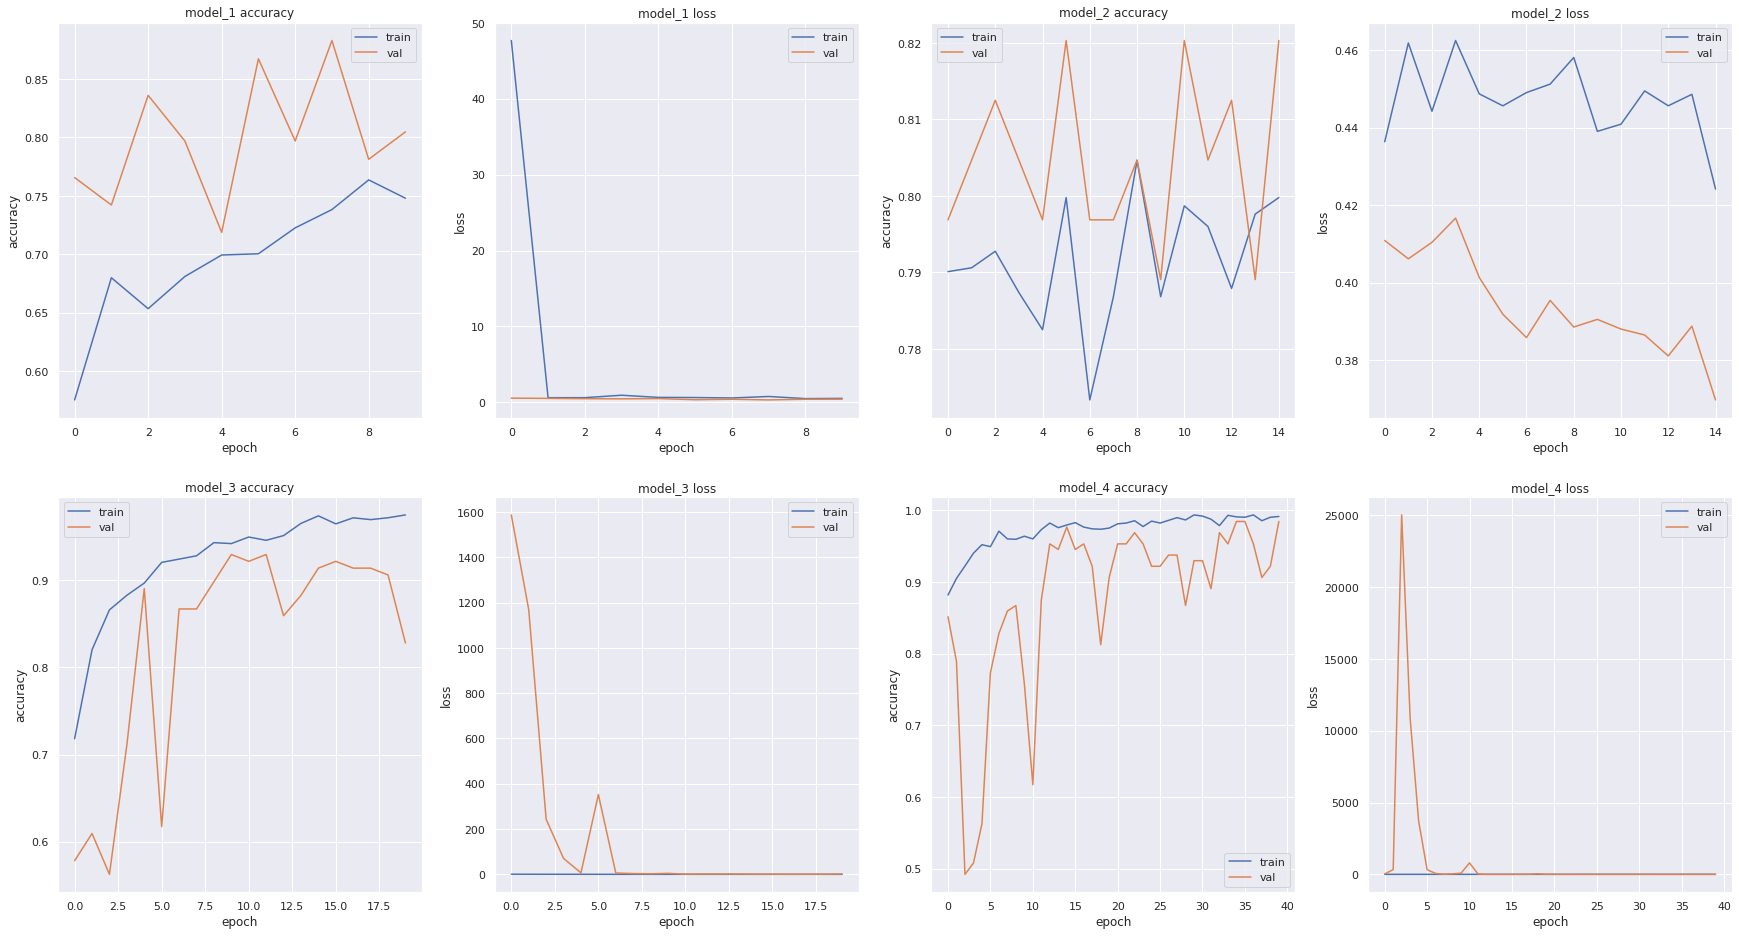

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Define o tema dos gráficos
sns.set_theme(context='notebook',style='darkgrid')

# Cria oito subplots para os gráficos de acc e loss dos quatro modelos
fig, axs = plt.subplots(2, 4, figsize=(30,16))

# Variáveis auxiliares ao plot
row = 0
col = 0
model_counter = 1

history_db = pd.read_csv(os.path.join(OUTPUT_PATH, 'history_model1.csv'))
history1_db = pd.read_csv(os.path.join(OUTPUT_PATH, 'history_model2.csv'))
history2_db = pd.read_csv(os.path.join(OUTPUT_PATH, 'history_model3.csv'))
history3_db = pd.read_csv(os.path.join(OUTPUT_PATH, 'history_model4.csv'))

for history in [history_db, history1_db, history2_db, history3_db]:
    # Imprime os gráficos de acurácia e val acurácia
    axs[row, col].plot(history['accuracy'])
    axs[row, col].plot(history['val_accuracy'])
    axs[row, col].set_title('model_{} accuracy'.format(model_counter))
    axs[row, col].set_ylabel('accuracy')
    axs[row, col].set_xlabel('epoch')
    axs[row, col].legend(['train', 'val'], loc='best')

    # Imprime os gráficos de loss e val loss
    axs[row, col+1].plot(history['loss'])
    axs[row, col+1].plot(history['val_loss'])
    axs[row, col+1].set_title('model_{} loss'.format(model_counter))
    axs[row, col+1].set_ylabel('loss')
    axs[row, col+1].set_xlabel('epoch')
    axs[row, col+1].legend(['train', 'val'], loc='best')

    # Lógica para o plot organizado
    model_counter += 1
    col += 2
    if col+1 >= 4:
        col = 0
        row +=1

# Imprime o gráfico na tela
plt.savefig('{}/Graphics.png'.format(OUTPUT_PATH))
plt.show()

Através dos gráficos podemos ter um "overview" de qual dos três modelos ficaram melhor. Entretanto, para termos certeza disso, vamos comparar esses três modelos utilizando os resultados obtidos no dataset de test.

Utilizaremos três formas de medir a qualidade dos nossos modelos. As primeiras duas métricas consistem no **Ranked Accuracy**, que basicamente é uma coleção de conceitos (rank-1, rank-5, rank-n) para medir a acurácia de um modelo de rede neural, sendo mais utilizado nos artigos e literatura de visão computacional. Além disso, eles podem ser chamados, também, de **top-1 accuracy**. Sendo que uma está utilizando a imagem inteira para a predição, enqaunto que a outra utilizará a técnica de **crop**, isto é, iremos cortar a imagem em 5 imagens (bordas + centro) e realizar a predição, tal que a acurácia rank-1 será a média das cinco predições.

A última métrica, portanto, será o valor do loss do nosso modelo na base de teste. Comparando esses 4 dados, vamos poder concluir qual o melhor modelo para o nosso caso.



In [47]:
# Importa bibliotecas necessárias
import numpy as np

# Cria função para o cálculo do rank-1 e rank-5
def rank5_accuracy(preds, labels):
    # Inicializa as variáveis rank-1 e rank-5
    rank1 = 0
    rank5 = 0

	# Cria loop sobre as predições e as classes "gound-truth"
    for (p, gt) in zip(preds, labels):
        # Organiza as probabilidades pelos seus índices em ordem decrescente
        # para que palpites de confianças mais altas fiquem na frente da lista
        p = np.argsort(p)[::-1]

        # Checa se a classe "ground-truth" está nas top-5 predições
        if gt in p[:5]:
            rank5 += 1

        # Checa se a classe "ground-truth" está na top-5 predições
        if gt == p[0]:
            rank1 += 1

	# Computa as acurácias finais de rank-1 e rank-5
    rank1 /= float(len(preds))
    rank5 /= float(len(preds))

    # Retorna uma tupla com as acurácias de rank-1 e rank-5
    return (rank1, rank5)

Agora, vamos realizar todas as manipulações necessárias para a avaliação dos modelos.

In [48]:
# Importa as bibliotecas necessárias
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import progressbar
import json

# Carrega as médias RGB para o conjunto de treino
means = json.loads(open(DATASET_MEAN).read())

# Inicializa os preprocessadores das imagens
sp = SimplePreprocessor(224, 224)
mp = MeanPreprocessor(means["R"], means["G"], means["B"])
cp = CropPreprocessor(224, 224)
iap = ImageToArrayPreprocessor()

# Cria um DataFrame para armazenar as métricas
models_metrics = pd.DataFrame(columns=["models", "trainable_layers", "rank-1", "rank-1_crops", "test_loss"])
models_metrics.models = ["model_1", "model_2", "model_3", "model_4"]
models_metrics.trainable_layers = ["Head", "165", "139", "93"]

# Criando variável para armazenar as matrizes de confusão
list_cm = []

# Cria loop sobre todos os quatro modelos
for i in range(0, 4):
    # Carrega o modelo pre-treinado
    print("[INFO] loading model_{}...".format(i))
    model = load_model(os.path.join(MODEL_PATH, 'model{}.model'.format(i+1)))

    # Inicializa o gerador do dataset de teste e realiza as predições
    testGen = HDF5DatasetGenerator(TEST_HDF5, 64,
                                   preprocessors=[sp, mp, iap], classes=2)
    print("[INFO] predicting on test data (no crops)...")
    predictions = model.predict(testGen.generator(),
                                steps=testGen.numImages // 64,
                                max_queue_size=10)
    
    # Computa a acurácia e o loss do modelo pelo evaluate()
    results = model.evaluate(testGen.generator(),
                             steps=testGen.numImages // 64,
                             max_queue_size=10)
    models_metrics["test_loss"][i] = round(results[0], 4) 

    # Computa as acurácias de rank-1 e rank-5
    (rank1, _) = rank5_accuracy(predictions, testGen.db["labels"])
    print("[INFO] rank-1: {:.2f}%".format(rank1 * 100))
    models_metrics["rank-1"][i] = round(rank1, 4)

    # Transformando predições 2d para 1d
    predictions_1d = []
    for prediction in predictions:
        if prediction[0] > prediction[1]:
            predictions_1d.append(0)
        else:
            predictions_1d.append(1)

    # Criando matrix de confusão
    print("[INFO] creating confusion matrix")
    cm = confusion_matrix(testGen.db["labels"][:192], predictions_1d)
    list_cm.append(cm)

    # Fecha o gerador do conjunto de test
    testGen.close()

    # Reinicializa o gerador do conjunto de teste, desta vez excluindo o
    # SimplePreprocessor
    testGen = HDF5DatasetGenerator(TEST_HDF5, 64,
                                   preprocessors=[mp], classes=2)
    predictions = []

    # Inicializa a barra de progresso
    widgets = ["Evaluating: ", progressbar.Percentage(), " ", progressbar.Bar(), " ", progressbar.ETA(), "\n"]
    pbar = progressbar.ProgressBar(maxval=testGen.numImages // 64,widgets=widgets).start()

    # Cria loop sobre um passo único dos dados de teste
    for (k, (images, labels)) in enumerate(testGen.generator(passes=1)):
	    # Cria loop sobre cada imagem individualmente
	    for image in images:
		    # Aplica o preprocessador de corte na imagem para gerar 10 cortes
            # separados, depois convert eles de imagens para arrays
		    crops = cp.preprocess(image)
		    crops = np.array([iap.preprocess(c) for c in crops],
                       dtype="float32")

		    # Realiza as predições nos cortes e então tira a médias de todos
            # para obter a predição final
		    pred = model.predict(crops)
		    predictions.append(pred.mean(axis=0))

	    # Atualiza a barra de progresso
	    pbar.update(k)

    # Computa as acurácias de rank-1 e rank-5
    pbar.finish()
    print("[INFO] predicting on test data (with crops)...")
    (rank1_crops, _) = rank5_accuracy(predictions, testGen.db["labels"])
    print("[INFO] rank-1_crops: {:.2f}%".format(rank1_crops * 100))
    models_metrics["rank-1_crops"][i] = round(rank1_crops, 4)
    print("\n\n") 
    testGen.close()

[INFO] loading model_0...
[INFO] predicting on test data (no crops)...
3/3 [==============================] - 2s 559ms/step - loss: 0.4232 - accuracy: 0.7760


Evaluating: N/A% |                                            | ETA:  --:--:--


[INFO] rank-1: 77.60%
[INFO] creating confusion matrix


Evaluating: N/A% |                                            | ETA:  --:--:--
Evaluating:  33% |##############                              | ETA:   0:00:23
Evaluating:  66% |#############################               | ETA:   0:00:08
Evaluating: 100% |############################################| ETA:  00:00:00
Evaluating: 100% |############################################| Time:  0:00:21



[INFO] predicting on test data (with crops)...
[INFO] rank-1_crops: 86.80%



[INFO] loading model_1...
[INFO] predicting on test data (no crops)...
3/3 [==============================] - 2s 560ms/step - loss: 0.3800 - accuracy: 0.8021


Evaluating: N/A% |                                            | ETA:  --:--:--


[INFO] rank-1: 80.21%
[INFO] creating confusion matrix


Evaluating: N/A% |                                            | ETA:  --:--:--
Evaluating:  33% |##############                              | ETA:   0:00:22
Evaluating:  66% |#############################               | ETA:   0:00:08
Evaluating: 100% |############################################| ETA:  00:00:00
Evaluating: 100% |############################################| Time:  0:00:20



[INFO] predicting on test data (with crops)...
[INFO] rank-1_crops: 86.80%



[INFO] loading model_2...
[INFO] predicting on test data (no crops)...
3/3 [==============================] - 2s 563ms/step - loss: 1.5748 - accuracy: 0.8438


Evaluating: N/A% |                                            | ETA:  --:--:--


[INFO] rank-1: 84.38%
[INFO] creating confusion matrix


Evaluating: N/A% |                                            | ETA:  --:--:--
Evaluating:  33% |##############                              | ETA:   0:00:20
Evaluating:  66% |#############################               | ETA:   0:00:08
Evaluating: 100% |############################################| ETA:  00:00:00
Evaluating: 100% |############################################| Time:  0:00:20



[INFO] predicting on test data (with crops)...
[INFO] rank-1_crops: 88.80%



[INFO] loading model_3...
[INFO] predicting on test data (no crops)...
3/3 [==============================] - 2s 572ms/step - loss: 0.2148 - accuracy: 0.9688


Evaluating: N/A% |                                            | ETA:  --:--:--


[INFO] rank-1: 96.88%
[INFO] creating confusion matrix


Evaluating: N/A% |                                            | ETA:  --:--:--
Evaluating:  33% |##############                              | ETA:   0:00:20
Evaluating:  66% |#############################               | ETA:   0:00:07
Evaluating: 100% |############################################| ETA:  00:00:00
Evaluating: 100% |############################################| Time:  0:00:19



[INFO] predicting on test data (with crops)...
[INFO] rank-1_crops: 98.80%





In [49]:
models_metrics

,models,trainable_layers,rank-1,rank-1_crops,test_loss
0,model_1,Head,0.776,0.868,0.4232
1,model_2,165,0.8021,0.868,0.38
2,model_3,139,0.8438,0.888,1.5748
3,model_4,93,0.9688,0.988,0.2148


Desta forma, podemos perceber que apesar dos primeiros modelos terem uma acurácia consideravelmente abaixo dos dois últimos, o test_loss desses modelo se encontram bem abaixo também. 

Uma justificativa para esse comportamento não esperado está no fato de que o resultado da nossa CNN consiste em dois valores ativados pela função softmax. Portanto, tais valores podem variar de $0$ a $1$, de tal forma que a classe da imagem é escolhida de acordo com o maior valor.

Dessa forma, podemos concluir que os valores de saída dos últimos modelos estão mais próximos do valor central $0.5$, apesar de possuir uma acurácia maior, podemos dizer que a confiança dessa acurácia se torna menor.

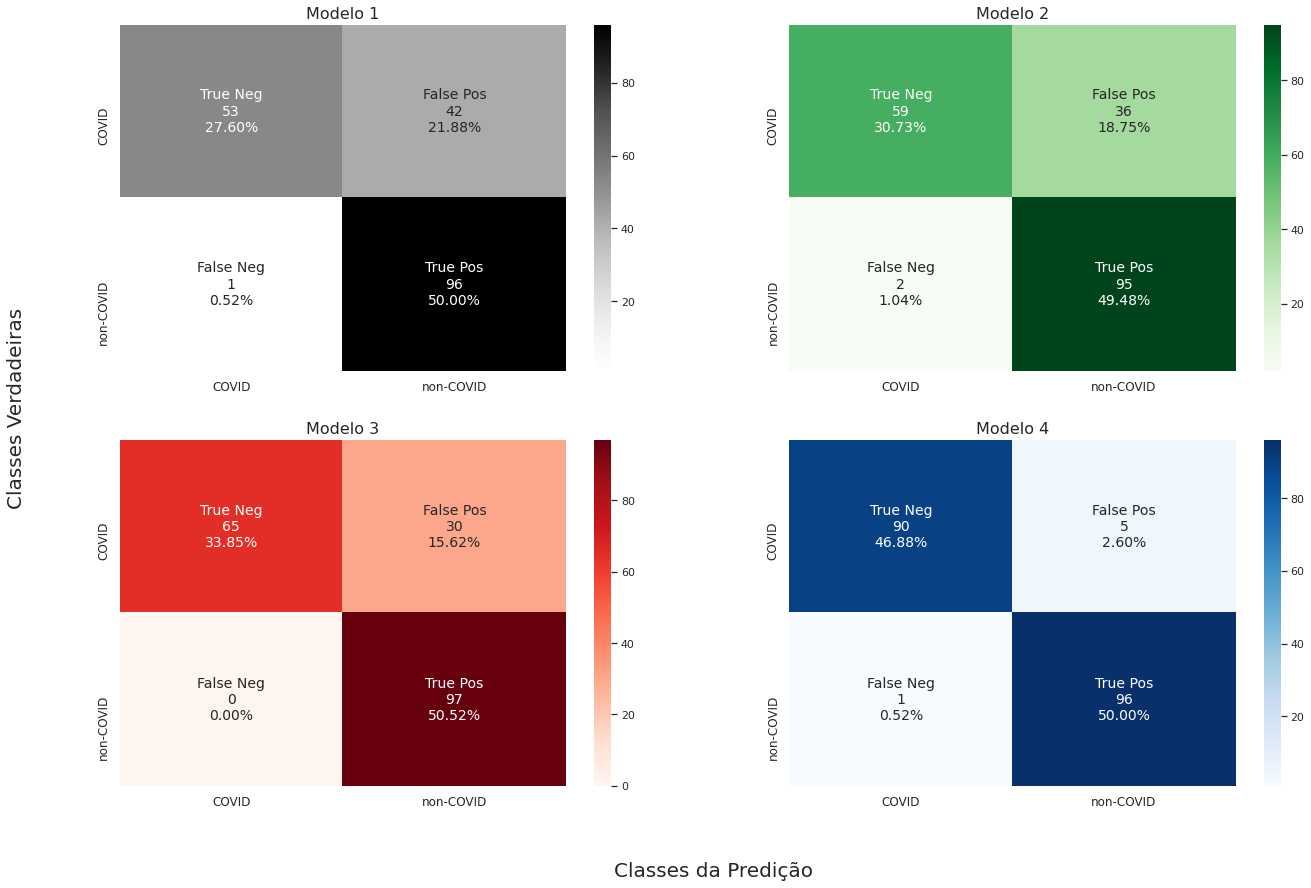

In [50]:
# Importa bibliotecas necessárias
import seaborn as sns
import numpy as np

# Cria subplots
fig, axs = plt.subplots(2,2, figsize=(22, 14))

# Inicializa variáveis úteis
ticklabels = ["COVID", "non-COVID"]
cmaps = ["Greys", "Greens", "Reds", "Blues"]
row = 0
col = 0

# Incia loop sobre as matrizes de confusões
for i in range(len(list_cm)):
    # Cria labels personalizadas
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in list_cm[i].flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in list_cm[i].flatten()/np.sum(list_cm[i])]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    # Plota o gráfico de calor das matriz de confusão
    sns.heatmap(list_cm[i],
                annot=labels,
                ax=axs[row][col],
                fmt='',
                cmap=cmaps[i],
                cbar=True,
                annot_kws={"size": 14})
    axs[row][col].set_title("Modelo {}".format(i+1), fontsize=16)
    axs[row][col].set_xticklabels(ticklabels, fontsize=12)
    axs[row][col].set_yticklabels(ticklabels, fontsize=12)

    # Incrementa coluna e linha
    col += 1
    if col >= 2:
        row += 1
        col = 0

# Configura as labels em comum
fig.text(0.5, 0.04, 'Classes da Predição', ha='center', va='center', fontsize=20)
fig.text(0.06, 0.5, 'Classes Verdadeiras', ha='center', va='center', rotation='vertical', fontsize=20)

# Salva o gráfico como uma figura
plt.savefig(os.path.join(OUTPUT_PATH, 'Confusion_Matrix.png'))
# Imprime o gráfico na tela
plt.show()

In [51]:
!cp -r /content/covid_non-covid /content/drive/MyDrive/Engenharia\ Elétrica/Deep\ Learning